In [1]:
# if anyone else runs this you need to change the absolute path to your own

import os
os.chdir('c:\\Users\\danaceau\\Documents\\MLM_2025\\UWMadisonMLM25')

In [2]:
from transformers import AutoTokenizer, EsmModel
import pandas as pd
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from LocalLibrary import SequenceFormatter as sf
import seaborn as sns

## Define Functions


In [3]:
def create_paneled_scatterplot(data):
    """
    Generates and displays a paneled scatterplot for all unique pairs of columns
    from a given n x 4 numpy array.

    Args:
        data (np.ndarray): A NumPy array with shape (n, 4).
    """
    # Validate the input array shape
    if not isinstance(data, np.ndarray) or data.shape[1] != 4:
        raise ValueError("Input must be a NumPy array with 4 columns.")

    # --- Plotting Setup ---
    # There are 6 unique combinations of 2 columns from a set of 4 (4 choose 2).
    # We will arrange these in a 2x3 grid of subplots.
    fig, axes = plt.subplots(2, 3, figsize=(15, 9))
    
    # Flatten the 2D axes array into a 1D array for easier iteration
    axes = axes.flatten()

    # Create descriptive labels for the columns
    column_labels = [f'PC {i+1}' for i in range(4)]

    # --- Generate Plots ---
    plot_index = 0
    # Iterate through each column index `i`
    for i in range(data.shape[1]):
        # Iterate through each subsequent column index `j` to create unique pairs
        for j in range(i + 1, data.shape[1]):
            ax = axes[plot_index]
            
            # Create a scatterplot of column i vs. column j
            ax.scatter(data[:, i], data[:, j], alpha=0.7, edgecolors='k', s=50)
            
            # Set the title and labels for the subplot
            ax.set_title(f'{column_labels[i]} vs. {column_labels[j]}', fontsize=12)
            ax.set_xlabel(column_labels[i], fontsize=10)
            ax.set_ylabel(column_labels[j], fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.6)
            
            plot_index += 1
    plt.show()

In [4]:
def get_pca_df(seq_emb_df:pd.DataFrame, n_pc=10, dim_emb=320):
    pca_model = PCA(n_components=n_pc)
    pca_model = pca_model.fit(seq_emb_df.iloc[:,:dim_emb])
    pca_embs_wvars = pca_model.transform(seq_emb_df.iloc[:,:dim_emb])
    pca_emb_df = pd.concat([pd.DataFrame(pca_embs_wvars, index=seq_emb_df.iloc[:,dim_emb:].index,
                                        columns=[f'PC_{i}' for i in range(n_pc)]), seq_emb_df.iloc[:,dim_emb:]], axis=1)
    return pca_emb_df


In [5]:
def create_paneled_scatterplot_df(data:pd.DataFrame, hue_var:str, n_pcs=4, **kwargs):
    """
    Generates and displays a paneled scatterplot for all unique pairs of columns
    from a given n x 4 numpy array.

    Args:
        data (np.ndarray): A NumPy array with shape (n, 4).
    """
    # Validate the input array shape
    # --- Plotting Setup ---
    # There are 6 unique combinations of 2 columns from a set of 4 (4 choose 2).
    # We will arrange these in a 2x3 grid of subplots.
    fig, axes = plt.subplots(2, 3, figsize=(13, 7))
    
    # Flatten the 2D axes array into a 1D array for easier iteration
    axes = axes.flatten()

    # Create descriptive labels for the columns
    column_labels = [f'PC_{i}' for i in range(4)]

    # --- Generate Plots ---
    plot_index = 0
    # Iterate through each column index `i`
    for i in range(n_pcs):
        # Iterate through each subsequent column index `j` to create unique pairs
        for j in range(i + 1, n_pcs):
            ax = axes[plot_index]
            
            # Create a scatterplot of column i vs. column j
            sns.scatterplot(data, x=f'PC_{i}', y=f'PC_{j}', hue=hue_var, ax=ax, legend=(plot_index == 0),**kwargs)
            ax.set_xlabel(column_labels[i], fontsize=10)
            ax.set_ylabel(column_labels[j], fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.6)
            if plot_index == 0:
                ax.legend(bbox_to_anchor=(-0.1, 1))
            
            plot_index += 1
    plt.tight_layout()
    plt.show()

In [6]:
seq_table = pd.read_csv("Config\\sequence_data.csv")
proteins = seq_table['Sequence'].to_list()

In [7]:
seq_table['Sequence'].str.len().value_counts()

Sequence
174    3
360    2
326    2
505    2
196    2
      ..
138    1
204    1
219    1
384    1
83     1
Name: count, Length: 129, dtype: int64

In [8]:
from sklearn.decomposition import PCA

In [9]:
# This is the 35M Param ESM model we can use whatever, but I only have cpu resources 
# DW about the warning, it just does that
esm_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(esm_name)
model = EsmModel.from_pretrained(esm_name)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Embed WT sequences to learn to use ESM and make a quick plot

In [80]:
# Tokenize sequences
tokenized_seqs = tokenizer(proteins, padding=True, return_tensors="pt")

In [81]:
# Make some batches (THis is for running on a laptop)
inds = [5*i for i in range(tokenized_seqs['input_ids'].shape[0]//5 + 1)]
batched_seqs = [{key:tokenized_seqs[key][ind1:ind2, :] for key in tokenized_seqs.keys()} for ind1, ind2 in zip(inds[:-1], inds[1:])]

In [82]:
# We're gonna batch this bc I have 16gb ram on my laptop and I don't have GPUs for PR
model.eval()
batched_res = []
for i, batch in enumerate(batched_seqs):
    with torch.no_grad():
        model_out = model(**batch)
    batched_res.append(model_out.pooler_output)
    print(f'finished batch {i}')
    del model_out
batched_res

finished batch 0


KeyboardInterrupt: 

In [13]:
np_embs = torch.cat(batched_res, dim=0).detach().numpy()
np_embs

array([[ 0.1361863 , -0.06730558, -0.14604113, ..., -0.06707063,
        -0.03830042,  0.10917517],
       [ 0.12563314,  0.01432397, -0.23303987, ..., -0.1574275 ,
        -0.02407403,  0.07864276],
       [ 0.1623456 ,  0.02123156, -0.1710814 , ..., -0.11399984,
         0.00452244,  0.11488131],
       ...,
       [ 0.13236551, -0.06433567, -0.15349412, ..., -0.07644798,
        -0.06174849,  0.09548871],
       [ 0.1190526 , -0.05066854, -0.14971675, ..., -0.10777874,
        -0.01173955,  0.16488433],
       [ 0.1645001 , -0.05967285, -0.23026304, ..., -0.09263757,
         0.02070582,  0.04990286]], shape=(135, 320), dtype=float32)

In [ ]:
np.savetxt("data\zdanaceau_out_data\esm_6M_embs.csv", np_embs, delimiter=',')

<>:2: SyntaxWarning: invalid escape sequence '\z'
<>:2: SyntaxWarning: invalid escape sequence '\z'
C:\Users\danaceau\AppData\Local\Temp\ipykernel_34004\3287000484.py:2: SyntaxWarning: invalid escape sequence '\z'
  np.savetxt("data\zdanaceau_out_data\esm_6M_embs.csv", np_embs, delimiter=',')
C:\Users\danaceau\AppData\Local\Temp\ipykernel_34004\3287000484.py:2: SyntaxWarning: invalid escape sequence '\z'
  np.savetxt("data\zdanaceau_out_data\esm_6M_embs.csv", np_embs, delimiter=',')


NameError: name 'np_embs' is not defined

In [15]:
np_embs = np.loadtxt("data\zdanaceau_out_data\esm_6M_embs.csv", delimiter=',')

<>:1: SyntaxWarning: invalid escape sequence '\z'
<>:1: SyntaxWarning: invalid escape sequence '\z'
C:\Users\danaceau\AppData\Local\Temp\ipykernel_34004\1187572732.py:1: SyntaxWarning: invalid escape sequence '\z'
  np_embs = np.loadtxt("data\zdanaceau_out_data\esm_6M_embs.csv", delimiter=',')


In [ ]:
pca_model = PCA(n_components=10)
pca_model = pca_model.fit(np_embs)
pca_embs = pca_model.transform(np_embs)
pca_embs

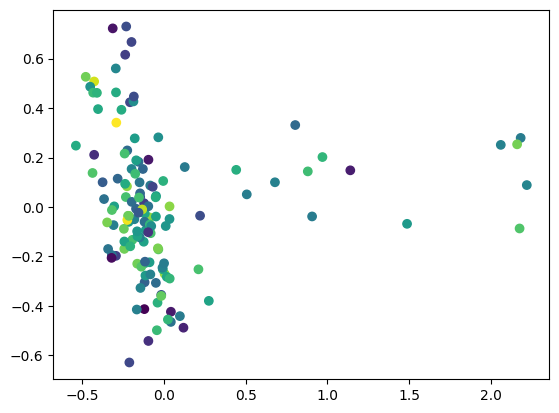

In [45]:
import matplotlib.pyplot as plt
plt.scatter(pca_embs[:, 0], pca_embs[:,1], c=pca_embs[:,3])

Text(0.5, 0, 'PC #')

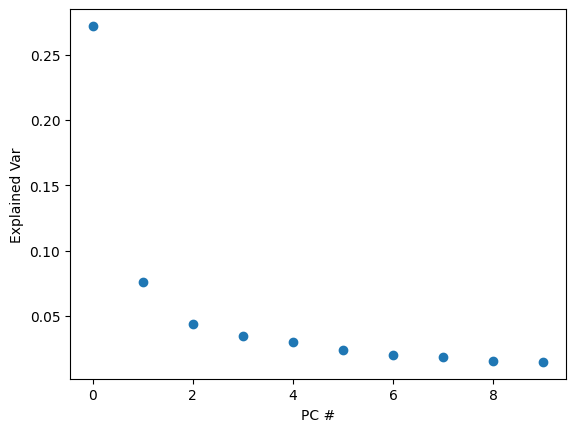

In [46]:
plt.scatter(list(range(len(pca_model.explained_variance_))), pca_model.explained_variance_)
plt.ylabel("Explained Var")
plt.xlabel("PC #")

In [47]:
def create_paneled_scatterplot(data):
    """
    Generates and displays a paneled scatterplot for all unique pairs of columns
    from a given n x 4 numpy array.

    Args:
        data (np.ndarray): A NumPy array with shape (n, 4).
    """
    # Validate the input array shape
    if not isinstance(data, np.ndarray) or data.shape[1] != 4:
        raise ValueError("Input must be a NumPy array with 4 columns.")

    # --- Plotting Setup ---
    # There are 6 unique combinations of 2 columns from a set of 4 (4 choose 2).
    # We will arrange these in a 2x3 grid of subplots.
    fig, axes = plt.subplots(2, 3, figsize=(15, 9))
    
    # Flatten the 2D axes array into a 1D array for easier iteration
    axes = axes.flatten()

    # Create descriptive labels for the columns
    column_labels = [f'PC {i+1}' for i in range(4)]

    # --- Generate Plots ---
    plot_index = 0
    # Iterate through each column index `i`
    for i in range(data.shape[1]):
        # Iterate through each subsequent column index `j` to create unique pairs
        for j in range(i + 1, data.shape[1]):
            ax = axes[plot_index]
            
            # Create a scatterplot of column i vs. column j
            ax.scatter(data[:, i], data[:, j], alpha=0.7, edgecolors='k', s=50)
            
            # Set the title and labels for the subplot
            ax.set_title(f'{column_labels[i]} vs. {column_labels[j]}', fontsize=12)
            ax.set_xlabel(column_labels[i], fontsize=10)
            ax.set_ylabel(column_labels[j], fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.6)
            
            plot_index += 1
    plt.show()

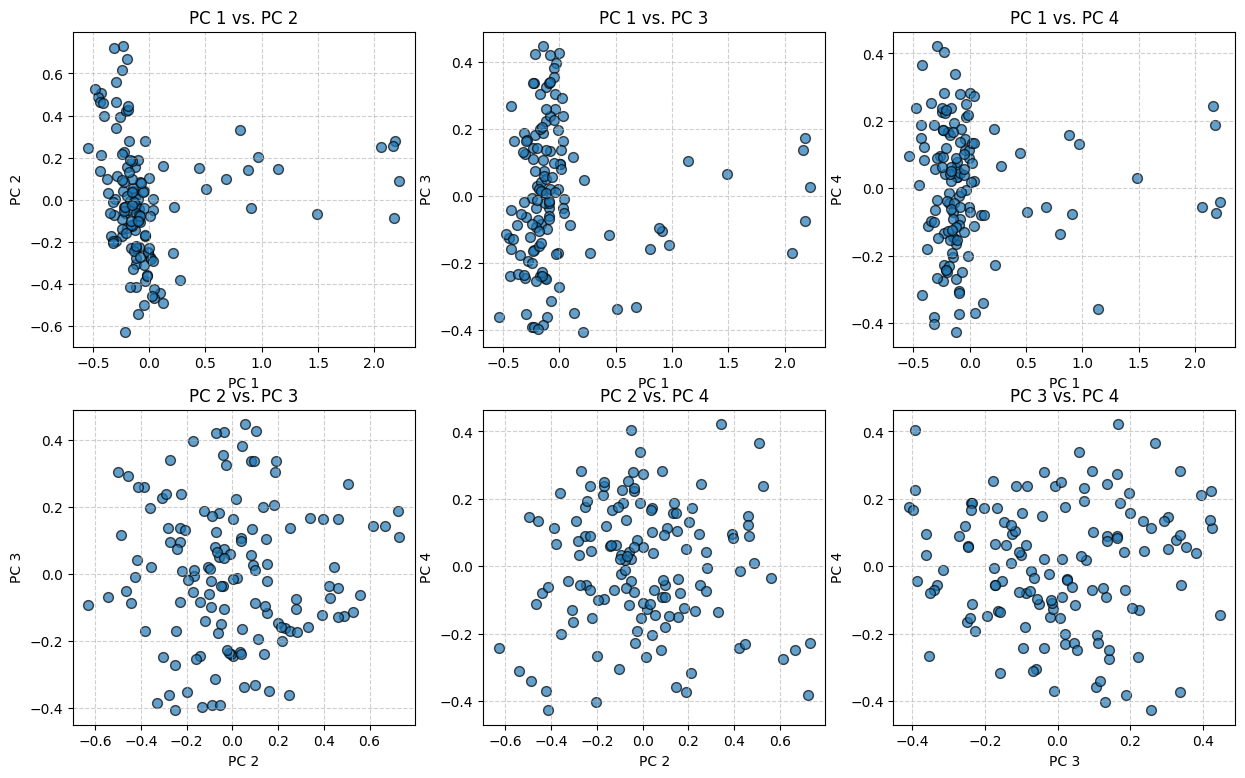

In [48]:
create_paneled_scatterplot(pca_embs[:,:4])

## Embed Variants

In [67]:
train_vnts = pd.read_csv("data\\mave-db-amino-acid-substitution-prediction\\train.csv")

### Preprocessing
Subsetting data for comp speed


In [68]:
vnt_sub_list =[]
for esnp in train_vnts['ensp'].unique():
    esnp_vnts = train_vnts[train_vnts['ensp'] == esnp]
    vnt_sub_list.append(esnp_vnts.iloc[np.random.choice(esnp_vnts.shape[0], size=10),:])
train_vnts_sub = pd.concat(vnt_sub_list, axis=0).reset_index(drop=True)
train_vnts_sub

,accession,scoreset,ensp,pos,ref_long,ref_short,alt_long,alt_short,score
0,urn:mavedb:00000069-a-2#884,urn:mavedb:00000069-a-2,ENSP00000252519.3,388,Gln,Q,Pro,P,0.183977
1,urn:mavedb:00000069-a-1#902,urn:mavedb:00000069-a-1,ENSP00000252519.3,347,Thr,T,Glu,E,-0.618603
2,urn:mavedb:00000069-a-1#486,urn:mavedb:00000069-a-1,ENSP00000252519.3,387,Ala,A,Asp,D,-0.138507
3,urn:mavedb:00000069-a-2#1936,urn:mavedb:00000069-a-2,ENSP00000252519.3,25,Ala,A,Gln,Q,1.384064
4,urn:mavedb:00000069-a-1#914,urn:mavedb:00000069-a-1,ENSP00000252519.3,345,His,H,Gln,Q,0.143171
...,...,...,...,...,...,...,...,...,...
1355,tmp:8758394a-9513-4948-ba9e-71a33a593406#5574,urn:mavedb:00001200-c-1,ENSP00000218099.2,266,Ala,A,Ile,I,0.016873
1356,tmp:8758394a-9513-4948-ba9e-71a33a593406#6454,urn:mavedb:00001200-c-1,ENSP00000218099.2,308,Ala,A,Gly,G,1.028989
1357,tmp:1a14f665-fcc5-4244-baae-e22da846c65f#6168,urn:mavedb:00001200-a-1,ENSP00000218099.2,294,Arg,R,Gln,Q,0.132003
1358,tmp:ec0eb518-1405-418a-a848-cc57fe8ce8bb#9187,urn:mavedb:00001200-b-1,ENSP00000218099.2,438,Lys,K,Lys,K,1.077897


Get variant sequences

In [69]:
train_vnts_sub['sequence'] = [
    sf.LoadSequenceData_FromDfRow(train_vnts_sub.iloc[idx,:]) for idx in range(train_vnts_sub.shape[0])
    ]
train_vnts_sub

,accession,scoreset,ensp,pos,ref_long,ref_short,alt_long,alt_short,score,sequence
0,urn:mavedb:00000069-a-2#884,urn:mavedb:00000069-a-2,ENSP00000252519.3,388,Gln,Q,Pro,P,0.183977,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...
1,urn:mavedb:00000069-a-1#902,urn:mavedb:00000069-a-1,ENSP00000252519.3,347,Thr,T,Glu,E,-0.618603,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...
2,urn:mavedb:00000069-a-1#486,urn:mavedb:00000069-a-1,ENSP00000252519.3,387,Ala,A,Asp,D,-0.138507,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...
3,urn:mavedb:00000069-a-2#1936,urn:mavedb:00000069-a-2,ENSP00000252519.3,25,Ala,A,Gln,Q,1.384064,MSSSSWLLLSLVAVTAAQSTIEEQQKTFLDKFNHEAEDLFYQSSLA...
4,urn:mavedb:00000069-a-1#914,urn:mavedb:00000069-a-1,ENSP00000252519.3,345,His,H,Gln,Q,0.143171,MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSSLA...
...,...,...,...,...,...,...,...,...,...,...
1355,tmp:8758394a-9513-4948-ba9e-71a33a593406#5574,urn:mavedb:00001200-c-1,ENSP00000218099.2,266,Ala,A,Ile,I,0.016873,MQRVNMIMAESPGLITICLLGYLLSAECTVFLDHENANKILNRPKR...
1356,tmp:8758394a-9513-4948-ba9e-71a33a593406#6454,urn:mavedb:00001200-c-1,ENSP00000218099.2,308,Ala,A,Gly,G,1.028989,MQRVNMIMAESPGLITICLLGYLLSAECTVFLDHENANKILNRPKR...
1357,tmp:1a14f665-fcc5-4244-baae-e22da846c65f#6168,urn:mavedb:00001200-a-1,ENSP00000218099.2,294,Arg,R,Gln,Q,0.132003,MQRVNMIMAESPGLITICLLGYLLSAECTVFLDHENANKILNRPKR...
1358,tmp:ec0eb518-1405-418a-a848-cc57fe8ce8bb#9187,urn:mavedb:00001200-b-1,ENSP00000218099.2,438,Lys,K,Lys,K,1.077897,MQRVNMIMAESPGLITICLLGYLLSAECTVFLDHENANKILNRPKR...


In [70]:
base_seq_map = seq_table.set_index('ID')['Sequence'].to_dict()
base_seq_map

{'ENSP00000336856.4': 'MENLMTSSTLPPLFADEDGSKESNDLATTGLNHPEVPYSSGATSSTNNPEFVEDLSQGQLLQSESSNAAEGNEQRHEDEQRSKRGGWSKGRKRKKPLRDSNAPKSPLTGYVRFMNERREQLRAKRPEVPFPEITRMLGNEWSKLPPEEKQRYLDEADRDKERYMKELEQYQKTEAYKVFSRKTQDRQKGKSHRQDAARQATHDHEKETEVKERSVFDIPIFTEEFLNHSKAREAELRQLRKSNMEFEERNAALQKHVESMRTAVEKLEVDVIQERSRNTVLQQHLETLRQVLTSSFASMPLPGSGETPTVDTIDSYMNRLHSIILANPQDNENFIATVREVVNRLDR',
 'ENSP00000309606.2': 'MEEAEELLLEGKKALQLAREPRLGLDLGWNPSGEGCTQGLKDVPPEPTRDILALKSLPRGLALGPSLAKEQRLGVWCVGDPLQPGLLWGPLEEESASKEKGEGVKPRQEENLSLGPWGDVCACEQSSGWTSLVQRGRLESEGNVAPVRISERLHLQVYQLVLPGSELLLWPQPSSEGPSLTQPGLDKEAAVAVVTEVESAVQQEVASPGEDAAEPCIDPGSQSPSGIQAENMVSPGLKFPTQDRISKDSQPLGPLLQDGDVDEECPAQAQMPPELQSNSATQQDPDGSGASFSSSARGTQPHGYLAKKLHSPSDQCPPRAKTPEPGAQQSGFPTLSRSPPGPAGSSPKQGRRYRCGECGKAFLQLCHLKKHAFVHTGHKPFLCTECGKSYSSEESFKAHMLGHRGVRPFPCPQCDKAYGTQRDLKEHQVVHSGARPFACDQCGKAFARRPSLRLHRKTHQVPAAPAPCPCPVCGRPLANQGSLRNHMRLHTGEKPFLCPHCGRAFRQRGNLRGHLRLHTGERPYRCPHCADAFPQLPELRRHLISHTGEAHLCPVCGKALRDPHTLRAHERLHSGERPFPCPQCGRAYTLATKLRRHLKSHLED

In [71]:
vnt_proteins = train_vnts_sub['sequence'].to_list()
tokenized_vnts = tokenizer(vnt_proteins, padding=True, return_tensors='pt')

In [72]:
# Yes I know this is not efficient
orig_prots = train_vnts_sub['ensp'].map(base_seq_map).to_list()
tokenized_orig = tokenizer(orig_prots, padding=True, return_tensors='pt')

### Compute embeddings 

Batch Sequences

In [ ]:
# Make some batches (THis is for running on a laptop)
inds = [10*i for i in range(tokenized_vnts['input_ids'].shape[0]//10 + 1)]
batched_pos = [train_vnts_sub.loc[ind1:ind2-1, 'pos'].to_list() for ind1, ind2 in zip(inds[:-1], inds[1:])]
batched_vnts = [{key:tokenized_vnts[key][ind1:ind2, :] for key in tokenized_vnts.keys()} for ind1, ind2 in zip(inds[:-1], inds[1:])]
batched_orig = [{key:tokenized_orig[key][ind1:ind2, :] for key in tokenized_orig.keys()} for ind1, ind2 in zip(inds[:-1], inds[1:])]

Get Embeddings

In [74]:
# We're gonna batch this bc I have 16gb ram on my laptop and I don't have GPUs for PR
# IK there is a more efficient way to do this too. I should have cached the whole AA level
#       seq embedding and then pulled aas from that cache. This was easier.
model.eval()
batched_vnt_emb = []
batched_orig_emb = []
batched_mut_aa_emb = []
batched_orig_aa_emb = []

for i, batch in enumerate(batched_vnts):
    with torch.no_grad():
        model_out_var = model(**batch)
        model_out_orig = model(**batched_orig[i])
    # Stack the mutants embeddings together
    # last_hidden_state has dimensionality (n_seqs, max_seq_len*, emb_dim)
    #   *I use this loosely theres some padding and stuff
    # BC the first index is padded we can just use the positions who's indices start at 1 so thats nice
    batch_mut_aa_emb = []
    batch_orig_aa_emb = []
    for seq_ind, pos in enumerate(batched_pos[i]):
        batch_mut_aa_emb.append(model_out_var.last_hidden_state[seq_ind, pos, :])
        batch_orig_aa_emb.append(model_out_orig.last_hidden_state[seq_ind, pos, :])
    batched_mut_aa_emb.append(torch.stack(batch_mut_aa_emb, dim=0))
    batched_orig_aa_emb.append(torch.stack(batch_orig_aa_emb, dim=0))
    # pooler output is (n_seqs, emb_dim) These are sequence embeddings
    batched_vnt_emb.append(model_out_var.pooler_output)
    batched_orig_emb.append(model_out_orig.pooler_output)
    print(f'finished batch {i}')
    del model_out_var
    del model_out_orig


finished batch 0
finished batch 1
finished batch 2
finished batch 3
finished batch 4
finished batch 5
finished batch 6
finished batch 7
finished batch 8
finished batch 9
finished batch 10
finished batch 11
finished batch 12
finished batch 13
finished batch 14
finished batch 15
finished batch 16
finished batch 17
finished batch 18
finished batch 19
finished batch 20
finished batch 21
finished batch 22
finished batch 23
finished batch 24
finished batch 25
finished batch 26
finished batch 27
finished batch 28
finished batch 29
finished batch 30
finished batch 31
finished batch 32
finished batch 33
finished batch 34
finished batch 35
finished batch 36
finished batch 37
finished batch 38
finished batch 39
finished batch 40
finished batch 41
finished batch 42
finished batch 43
finished batch 44
finished batch 45
finished batch 46
finished batch 47
finished batch 48
finished batch 49
finished batch 50
finished batch 51
finished batch 52
finished batch 53
finished batch 54
finished batch 55
fi

RuntimeError: cannot reshape tensor of 0 elements into shape [0, 4836, -1, 16] because the unspecified dimension size -1 can be any value and is ambiguous

Save Embeddings

In [10]:
np_vnt_embs = torch.cat(batched_vnt_emb, dim=0).detach().numpy()
np.savetxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_embs.csv", np_vnt_embs,
           delimiter=',')
np_orig_embs = torch.cat(batched_orig_emb, dim=0).detach().numpy()
np.savetxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_orig_embs.csv", np_orig_embs,
           delimiter=',')
np_vnt_aa_embs = torch.cat(batched_mut_aa_emb, dim=0).detach().numpy()
np.savetxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_aa_embs.csv", np_vnt_aa_embs,
           delimiter=',')
np_orig_aa_embs = torch.cat(batched_orig_aa_emb, dim=0).detach().numpy()
np.savetxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_orig_aa_embs.csv", np_orig_aa_embs,
           delimiter=',')
# Save this since subset can be different since its random and I forgot to seed
train_vnts_sub.to_csv("data\\zdanaceau_out_data\\seq_res_embs\\vnt_subset_info.csv")

<>:2: SyntaxWarning: invalid escape sequence '\z'
<>:5: SyntaxWarning: invalid escape sequence '\z'
<>:8: SyntaxWarning: invalid escape sequence '\z'
<>:11: SyntaxWarning: invalid escape sequence '\z'
<>:2: SyntaxWarning: invalid escape sequence '\z'
<>:5: SyntaxWarning: invalid escape sequence '\z'
<>:8: SyntaxWarning: invalid escape sequence '\z'
<>:11: SyntaxWarning: invalid escape sequence '\z'
C:\Users\danaceau\AppData\Local\Temp\ipykernel_6060\2177480116.py:2: SyntaxWarning: invalid escape sequence '\z'
  np.savetxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_embs.csv", np_vnt_embs,
C:\Users\danaceau\AppData\Local\Temp\ipykernel_6060\2177480116.py:5: SyntaxWarning: invalid escape sequence '\z'
  np.savetxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_orig_embs.csv", np_orig_embs,
C:\Users\danaceau\AppData\Local\Temp\ipykernel_6060\2177480116.py:8: SyntaxWarning: invalid escape sequence '\z'
  np.savetxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_aa_embs.csv", np_vnt_aa

NameError: name 'batched_vnt_emb' is not defined

Load embeddings (They take a couple hours)

### Explore Embeddings

In [33]:

np_vnt_embs= np.loadtxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_embs.csv", 
           delimiter=',')

np_orig_embs=np.loadtxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_orig_embs.csv", 
           delimiter=',')

np_vnt_aa_embs=np.loadtxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_aa_embs.csv", 
           delimiter=',')
np_orig_aa_embs = np.loadtxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_orig_aa_embs.csv",
           delimiter=',')
# Save this since subset can be different since its random and I forgot to seed
train_vnts_sub=pd.read_csv("data\\zdanaceau_out_data\\seq_res_embs\\vnt_subset_info.csv")

<>:1: SyntaxWarning: invalid escape sequence '\z'
<>:4: SyntaxWarning: invalid escape sequence '\z'
<>:7: SyntaxWarning: invalid escape sequence '\z'
<>:9: SyntaxWarning: invalid escape sequence '\z'
<>:1: SyntaxWarning: invalid escape sequence '\z'
<>:4: SyntaxWarning: invalid escape sequence '\z'
<>:7: SyntaxWarning: invalid escape sequence '\z'
<>:9: SyntaxWarning: invalid escape sequence '\z'
C:\Users\danaceau\AppData\Local\Temp\ipykernel_2452\2383516881.py:1: SyntaxWarning: invalid escape sequence '\z'
  np_vnt_embs= np.loadtxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_embs.csv",
C:\Users\danaceau\AppData\Local\Temp\ipykernel_2452\2383516881.py:4: SyntaxWarning: invalid escape sequence '\z'
  np_orig_embs=np.loadtxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_orig_embs.csv",
C:\Users\danaceau\AppData\Local\Temp\ipykernel_2452\2383516881.py:7: SyntaxWarning: invalid escape sequence '\z'
  np_vnt_aa_embs=np.loadtxt("data\zdanaceau_out_data\seq_res_embs\esm_6m_var_aa_embs.csv

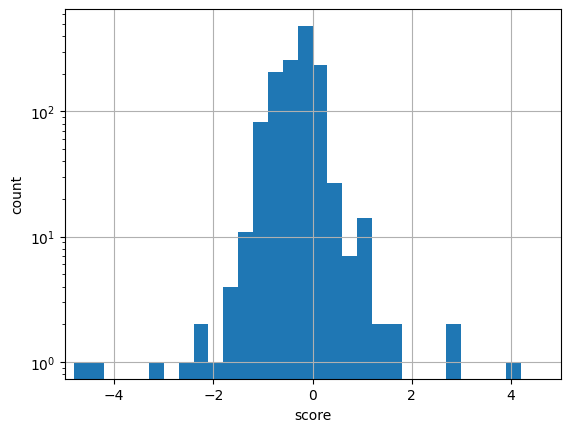

In [70]:
# Score distribution has some outliers, clip to +/-15
train_vnts_sub['score'].hist(bins=100)
plt.yscale('log')
plt.ylabel('count')
plt.xlabel('score')
plt.xlim(-5,5)
plt.show()

#### Full Seq Embeddings

In [89]:
train_vnts_sub['score'] = train_vnts_sub['score'].clip(-15,15)
train_vnts_sub['abs_score'] = train_vnts_sub['score'].abs()

In [90]:
seq_emb_df = pd.concat(
    [pd.concat([pd.DataFrame(np_orig_embs, index=train_vnts_sub.index), train_vnts_sub], axis=1),
     pd.concat([pd.DataFrame(np_vnt_embs, index=train_vnts_sub.index), train_vnts_sub], axis=1)],
     axis=0
)
seq_emb_df['prot_version'] = ['orig' for i in range(1360)] + ['var' for i in range(1360)]

PCA Plot
- It should be apparent that there is virtuall no diff in embedding here

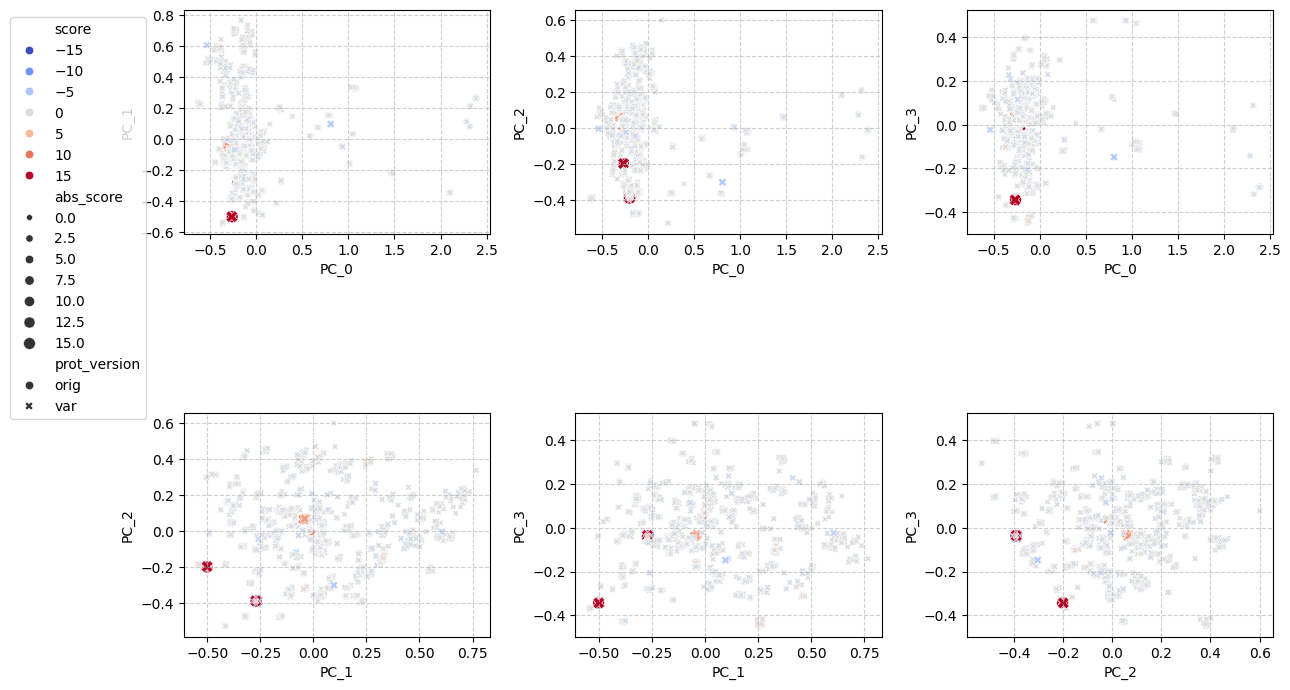

In [91]:
pca_emb_df = get_pca_df(seq_emb_df)
create_paneled_scatterplot_df(pca_emb_df, style='prot_version', hue_var='score', palette='coolwarm', size='abs_score'
                              )

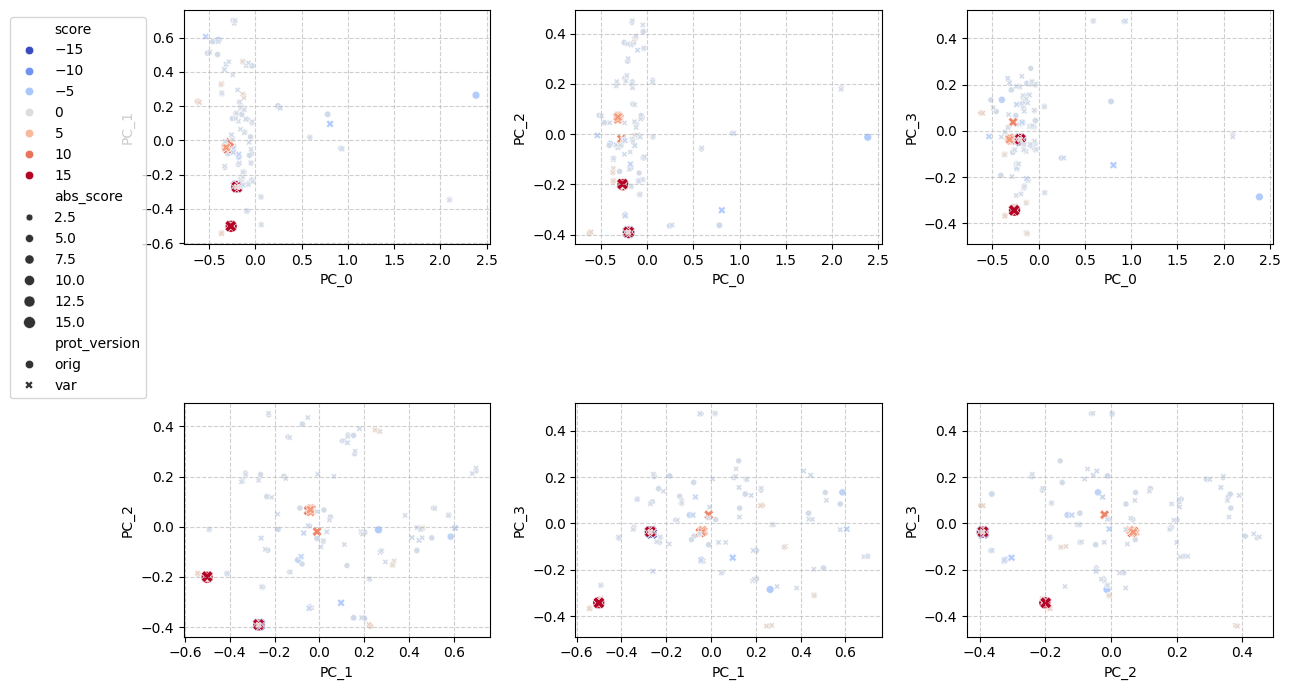

In [92]:
create_paneled_scatterplot_df(pca_emb_df[pca_emb_df['abs_score'] > 1],style='prot_version', 
                              hue_var='score', size='abs_score', palette='coolwarm')

Mutated AA embs
- Now we see a difference (not really apparent unless I get rid of all the 0s, hence subset to |score| > 1)

In [96]:
aa_emb_df = pd.concat(
    [pd.concat([pd.DataFrame(np_orig_aa_embs, index=train_vnts_sub.index), train_vnts_sub], axis=1),
     pd.concat([pd.DataFrame(np_vnt_aa_embs, index=train_vnts_sub.index), train_vnts_sub], axis=1)],
     axis=0
)
aa_emb_df['prot_version'] = ['orig' for i in range(1360)] + ['var' for i in range(1360)]

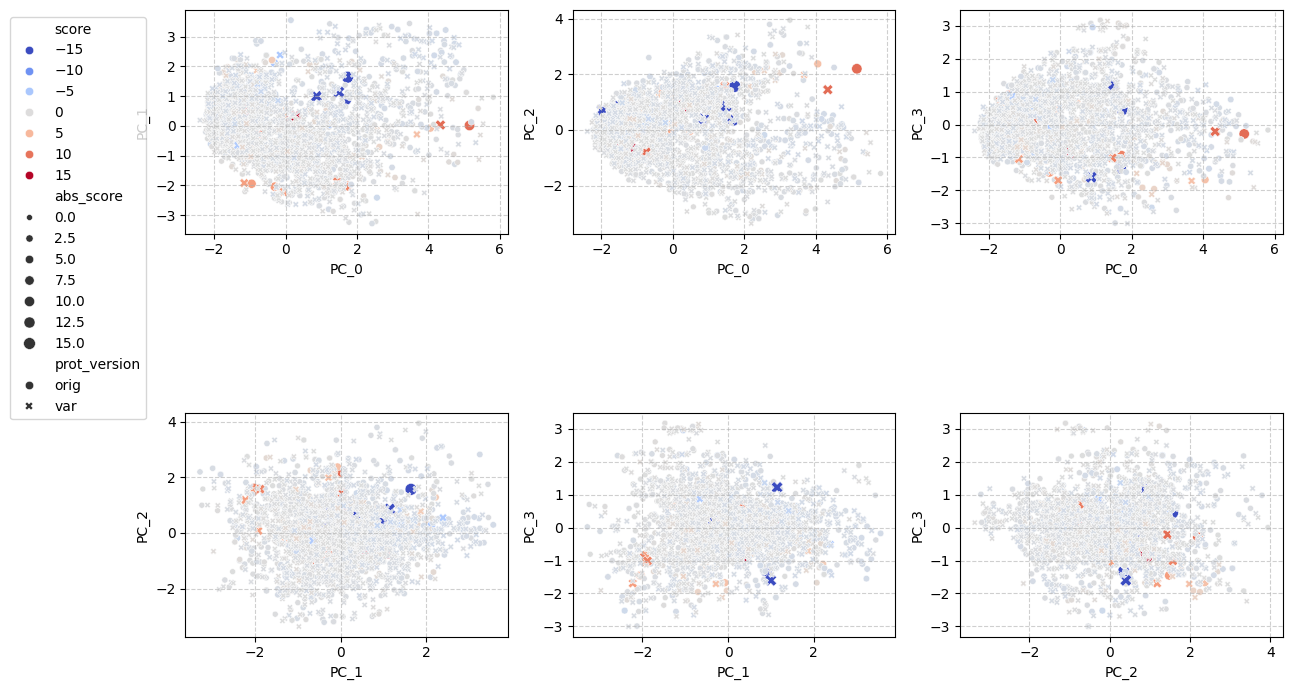

In [97]:
pca_emb_df = get_pca_df(aa_emb_df)
create_paneled_scatterplot_df(pca_emb_df,  style='prot_version', 
                              hue_var='score', size='abs_score', palette='coolwarm')

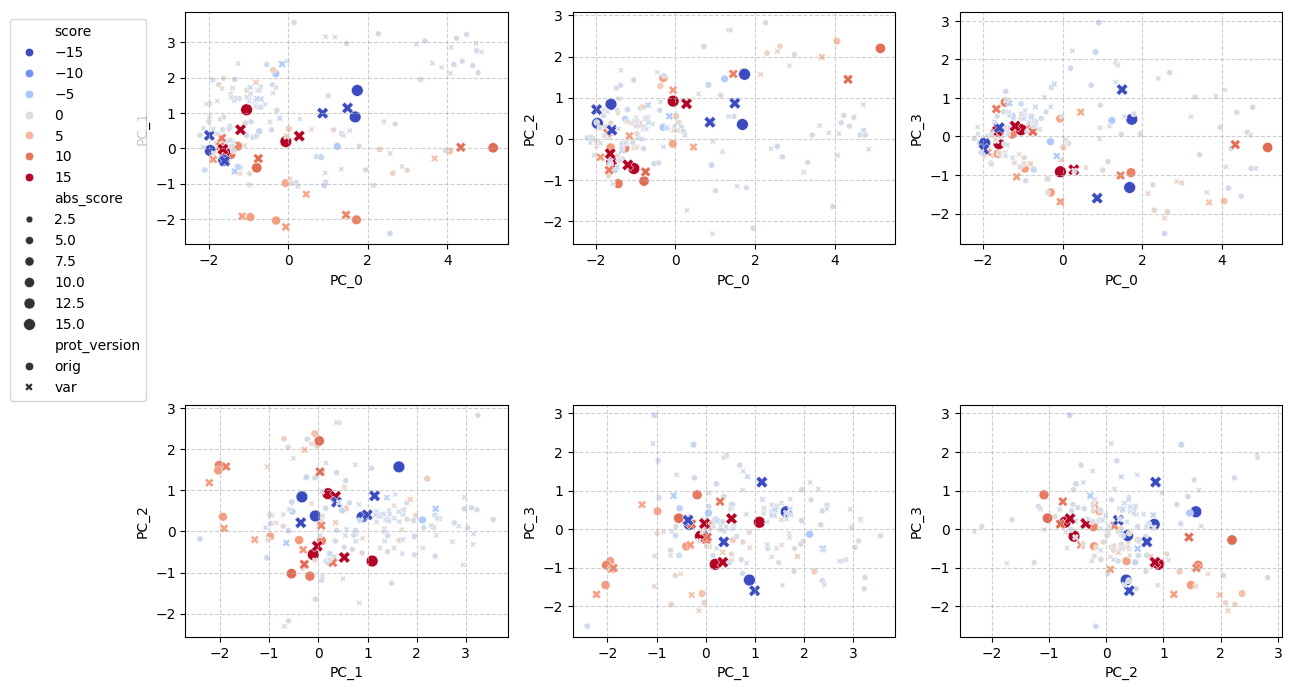

In [98]:
create_paneled_scatterplot_df(pca_emb_df[pca_emb_df['abs_score'] > 1],style='prot_version', 
                              hue_var='score', size='abs_score', palette='coolwarm')

Diffs between residue embeddings

In [99]:
aa_diff_emb_df = pd.concat(
    [pd.DataFrame(np_vnt_aa_embs - np_orig_aa_embs, index=train_vnts_sub.index), train_vnts_sub], axis=1
    )


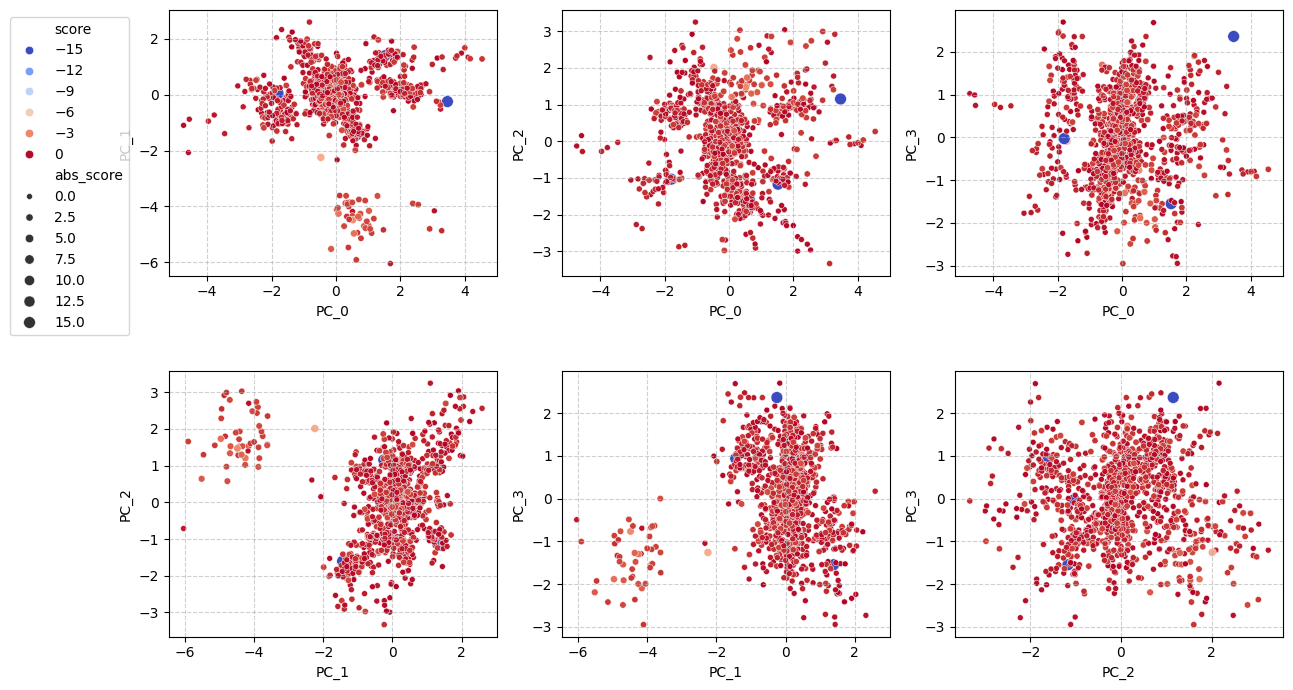

In [101]:
pca_emb_df = pca_emb_df = get_pca_df(aa_diff_emb_df)
create_paneled_scatterplot_df(pca_emb_df[pca_emb_df['score'] < 0.1], hue_var='score', size='abs_score', palette='coolwarm')

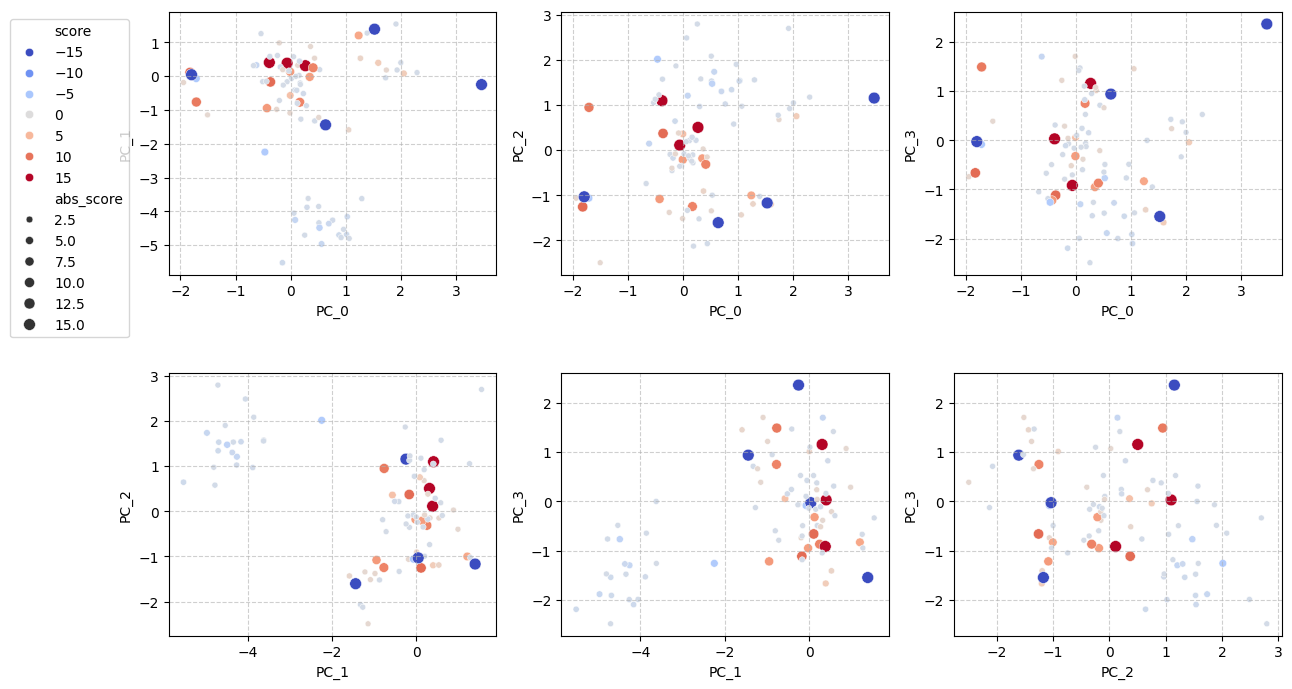

In [102]:
create_paneled_scatterplot_df(pca_emb_df[pca_emb_df['abs_score'] > 1],  hue_var='score', size='abs_score', palette='coolwarm')